In [265]:
%load_ext autoreload
%autoreload 2
from storytelling import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# select en events:
events = pd.read_csv("../dat/tweeterNews/events.csv.gz", header=None,
                     names=["Num","Date","TotalKeyWords","TotalTweets","Keywoards"])

In [85]:
events.sort_values("TotalTweets", ascending=False).head(10)

,Num,Date,TotalKeyWords,TotalTweets,Keywoards
4498,4499,2014-05-28,9,510920,angelou;pakistan;life;woman;maya;risk;dies;dea...
4883,4884,2014-06-12,22,452534,turtle;sao;win;national;follow;home;brazil;pol...
231,232,2013-09-10,32,423756,control;says;apple;december;india;four;gang;fo...
1965,1966,2014-02-02,10,338252,fans;bowl;see;sunday;blog;game;security;xlviii...
1977,1978,2014-02-03,16,313030,broncos;super;title;may;win;million;bowl;blog;...
1257,1258,2013-12-31,25,308703,celebrations;photo;globe;tonight;australia;yea...
1860,1861,2014-01-29,18,301448,boy;grimm;end;unemployment;veto;rep;reporter;y...
1737,1738,2014-01-23,13,281559,prime;ukraine;supreme;resisting;police;justin;...
1688,1689,2014-01-20,2,276219,king;luther
2701,2702,2014-03-08,35,271306,spotted;hairline;photo;slicks;airlines;malaysi...


In [ ]:
events.loc[4883, "Keywords"]

In [25]:
tweets = pd.read_csv("../dat/tweeterNews/tweets.csv.gz", names=["tid", "eid"])

In [26]:
tweets.head()

,tid,eid
0,371043469185540096,1
1,371043472397987841,1
2,371043478404222976,1
3,371043500814385152,1
4,371043512642719744,1


In [27]:
wildfire_yosemite = tweets[tweets["eid"]==5]

In [29]:
wildfire_yosemite.head()

,tid,eid
27927,370581177494941696,5
27928,370581180321910784,5
27929,370581197103300608,5
27930,370581385456545792,5
27931,370581492789153792,5


In [76]:
tids = list(wildfire_yosemite["tid"].values)
len(tids)

12488

In [73]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

In [74]:
writer = csv.writer(open("dat/wildfire_yosemite.csv", "wt"))
header = ["id", "text", "created_at", "retweet_count", "user_id", "user_followers_count",
          "rt_id", "rt_text", "rt_created_at", "rt_retweet_count", "rt_user_id", "rt_user_followers_count"]
writer.writerow(header)

143

In [77]:
i = 0; j = 100
while 1:
    tweet = api.statuses_lookup(tids[i:j])
    Tweets2CSV(tweet, writer)
    i += 100;
    j += 100;
    if j > len(tids):
        break
    if j >= len(tids):
        j = tids

In [88]:
tids.index(477150935882297344)

89933

In [89]:
len(tids)

452534

In [95]:
# 4884
event_id = 4884
event_tweets = tweets[tweets["eid"]==4884]
tids = list(event_tweets["tid"].values)
RetriveDataset(tids, api, "4884.csv")

In [96]:
# 4499
event_id = 4499
event_tweets = tweets[tweets["eid"]==event_id]
tids = list(event_tweets["tid"].values)
RetriveDataset(tids, api, "{}.csv".format(event_id))

In [97]:
# 232
event_id = 232
event_tweets = tweets[tweets["eid"]==event_id]
tids = list(event_tweets["tid"].values)
RetriveDataset(tids, api, "{}.csv".format(event_id))

In [100]:
yesemite = "/Users/jiayao/Work/Storytelling/src/dat/wildfire_yosemite.csv"
df = pd.read_csv(yesemite)

In [102]:
df.head(2)

,id,text,created_at,retweet_count,user_id,user_followers_count,rt_id,rt_text,rt_created_at,rt_retweet_count,rt_user_id,rt_user_followers_count
0,370586020070563841,RT @AP: Wildfire near Yosemite more than tripl...,Thu Aug 22 16:39:27 +0000 2013,74,141529750,5612,3.705746e+17,Wildfire near Yosemite more than triples in si...,Thu Aug 22 15:54:02 +0000 2013,74.0,51241574.0,13760070.0
1,370607666386579457,RT @DRUDGE_REPORT: Yosemite wildfire balloons ...,Thu Aug 22 18:05:27 +0000 2013,13,20715638,3786,3.706056e+17,Yosemite wildfire balloons to 84 square miles ...,Thu Aug 22 17:57:05 +0000 2013,13.0,14669951.0,1330723.0


In [150]:
df.shape

(5279, 12)

In [303]:
DC = TwitterCleaner()

In [304]:
Data = []
for i in range(df.shape[0]):
    Data.append(DC.Clean(df.loc[i, "text"]))

In [305]:
DC.corpusWC(Data, "yosemite.1gram.wc.txt")

In [306]:
vocabularies = pd.read_csv("yosemite.1gram.wc.txt", names=["Word", "Count"], delimiter="\t")["Word"].values[:200]
#vocabularies
BW = DC.BagOfWords(Data, vocabularies)

In [307]:
BW

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

(5279, 40)


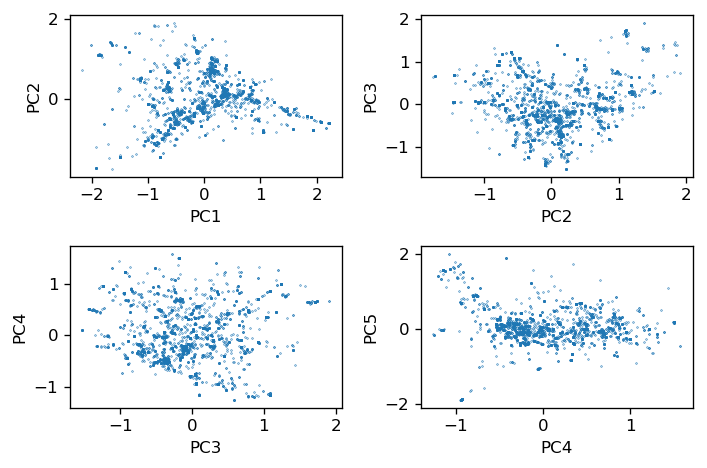

In [308]:
pca = PCA(n_components=40, svd_solver='arpack')
X = pca.fit_transform(BW)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()

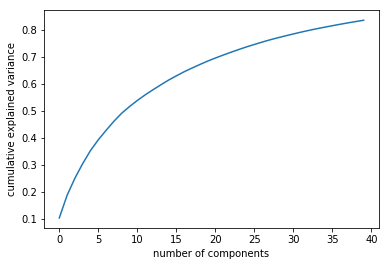

In [309]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [310]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :40])

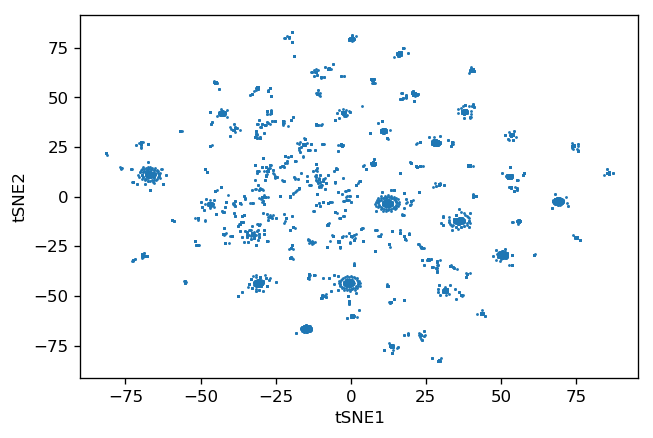

In [311]:
fig = plt.figure(dpi=120)
ax = plt.subplot(111)
ax.scatter(Y[:,0], Y[:,1],s=0.5)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.show()

In [316]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(Y)
groups = AssignCluster(Y, clusters)
centers = kmeans.cluster_centers_ 

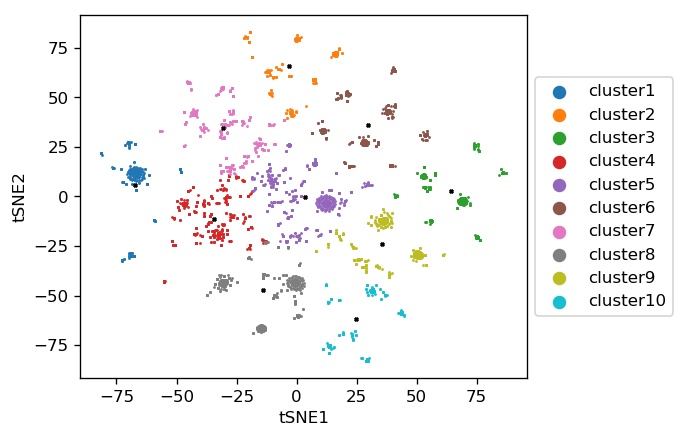

In [318]:
fig = plt.figure(dpi=120)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.show()

In [320]:
Agg = sklearn.cluster.AgglomerativeClustering(n_clusters=10)
clusters = Agg.fit_predict(Y)
groups = AssignCluster(Y, clusters)
#centers = kmeans.cluster_centers_ 

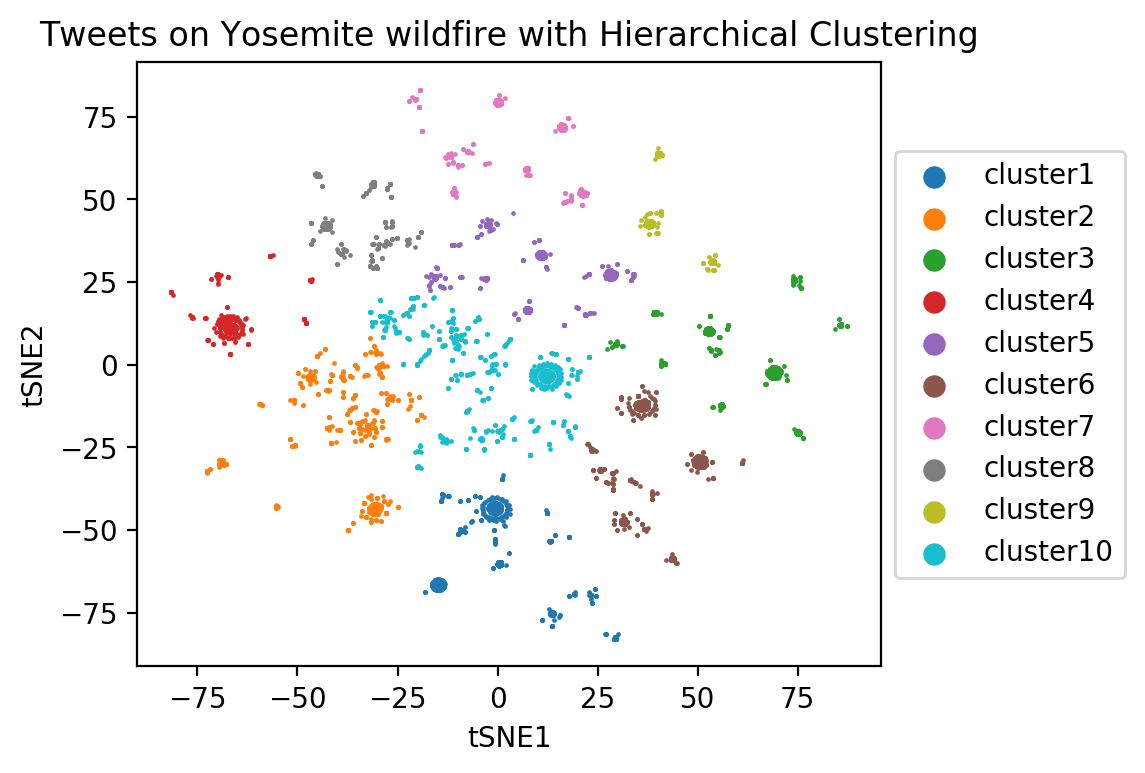

In [325]:
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
#ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.title("Tweets on Yosemite wildfire with Hierarchical Clustering")
plt.show()

In [322]:
for i in range(max(clusters)+1):
    print(i+1)
    topics = np.where(clusters==i)
    #print(topics)
    topics = topics[0]
    DC.showTopic(df, topics, Nshow=3)
    print("-------------")

1
RT @wildfiretoday: #RimFire near #Yosemite NP grows by 37,000 acres. Maps and info at http://t.co/UI8bPzhwVi #wildfire http://t.co/rIGYBMkV… Thu Aug 22 17:40:32 +0000 2013
rimfire near yosemite np grows acres maps info wildfire

RT @wildfiretoday: #RimFire near #Yosemite NP grows by 37,000 acres. Maps and info at http://t.co/UI8bPzhwVi #wildfire http://t.co/rIGYBMkV… Thu Aug 22 17:40:32 +0000 2013
rimfire near yosemite np grows acres maps info wildfire

RT @wildfiretoday: #RimFire near #Yosemite NP grows by 37,000 acres. Maps and info at http://t.co/UI8bPzhwVi #wildfire http://t.co/rIGYBMkV… Thu Aug 22 17:40:32 +0000 2013
rimfire near yosemite np grows acres maps info wildfire

RT @wildfiretoday: #RimFire near #Yosemite NP grows by 37,000 acres. Maps and info at http://t.co/UI8bPzhwVi #wildfire http://t.co/rIGYBMkV… Thu Aug 22 17:40:32 +0000 2013
rimfire near yosemite np grows acres maps info wildfire

-------------
2
Tourists flee wildfire near Yosemite http://t.co/nmrKkFSoiY Fri Au

In [200]:
topic1 = DC.sliceTopic(Y, (-75, -50), (-10, 10))
DC.showTopic(df, topic1)

#UCWRadio  Wildfire Near Yosemite Surges, Prompts Evacuations http://t.co/bCihX95bop #news Fri Aug 23 02:17:17 +0000 2013
ucwradio wildfire near yosemite surges prompts evacuations news


In [198]:
topic2 = DC.sliceTopic(Y, (-20, 0), (-50, -30))
DC.showTopic(df, topic2)

Tourists flee wildfire near Yosemite http://t.co/nmrKkFSoiY Fri Aug 23 03:10:01 +0000 2013
tourists flee wildfire near yosemite


In [199]:
topic2 = DC.sliceTopic(Y, (25, 50), (10, 30))
DC.showTopic(df, topic2)

Wildfire spreads to Yosemite National Park http://t.co/CD2W9mxzXh Fri Aug 23 15:16:58 +0000 2013
wildfire spreads yosemite national park


In [205]:
topic2 = DC.sliceTopic(Y, (0, 50), (-30, 20))
DC.showTopic(df, topic2, chooseOne=False)

RT @wildfiretoday: #RimFire near #Yosemite NP grows by 37,000 acres. Maps and info at http://t.co/UI8bPzhwVi #wildfire http://t.co/rIGYBMkV…
rimfire near yosemite np grows 37000 acres maps info wildfire

A wildfire is burning out of control near Yosemite. http://t.co/yl5EntEmvR
wildfire burning control near yosemite

#Wildfire near Yosemite burns out of control, threatens more than 2000 structures - http://t.co/EVGxUAtonP http://t.co/6YhJeIHQGr
wildfire near yosemite burns control threatens structures

NOW AT 11: Wildfire near Yosemite has more than tripled in size, w/ 2,500 buildings threatened by flames. WATCH LIVE: http://t.co/jP0YMFDDsC
wildfire near yosemite tripled size w 2500 buildings threatened flames watch live

RT @RobertaCBS5: @CBSSF Firefighters Lose Ground Against Growing Wildfire Near Yosemite. I will have Fire Weather 5 &amp; 6p KPIX 5. http://t.c…
cbssf firefighters lose ground growing wildfire near yosemite fire weather amp 6p kpix

MT @RichardYChang Update on #Califo

 http://t.co/vsoDpsdrzX http://t.co/KoVHsr6x8J
may fires put quickly everyone return homes safely

http://t.co/7Qm0V8eijz Fast-moving wildfire spreads to California's Yosemite National Park http://t.co/SHooq7BXNe


http://t.co/NkOZAqc3tr Fast-moving wildfire spreads to California's Yosemite National Park http://t.co/JJrBt4vDyz


http://t.co/3UgKMPeXIw Fast-moving wildfire spreads to California's Yosemite National Park http://t.co/1qDva97dCt


RT @DRUDGE_REPORT: Yosemite wildfire continues to burn out of control... http://t.co/TDM4LnSetL
yosemite wildfire continues burn control

RT @MSNNews: Yosemite wildfire growing at an alarming rate http://t.co/mx4dawOtYJ
yosemite wildfire growing alarming rate

RT @DRUDGE_REPORT: Yosemite wildfire continues to burn out of control... http://t.co/TDM4LnSetL
yosemite wildfire continues burn control

Inside the firestorm consuming #Yosemite via @vocativ http://t.co/V8enNKbXtm
inside firestorm consuming yosemite via vocativ

Rim fire at Yosemite grows a